In [1]:
from sklearn.datasets import load_digits
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline


In [11]:
#import libraries and functions to load the data
from digits import get_mnist
from matplotlib import pyplot as plt
import numpy as np


import torch
from torch import nn
from torch.utils.data import DataLoader, SubsetRandomSampler, Subset
from torchvision import datasets
from torchvision.transforms import ToTensor

In [3]:
# Download training data from open datasets.
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)
    

Labels are [0 1 2 3 4 5 6 7 8 9]
Labels are [0 1 2 3 4 5 6 7 8 9] 10000


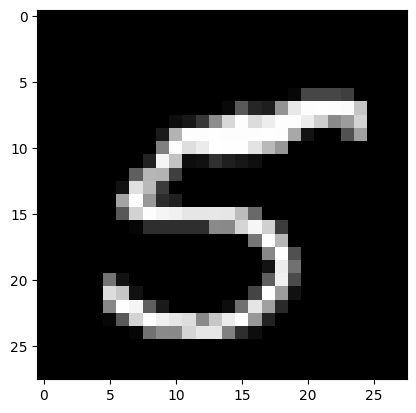

[ 16  38  43  52  61  75  86 102 110 113]
[46 49 54 65 67 78 80 81 88 89]
[ 0  4  7  9 11 22 23 26 45 51]
[ 6  8 10 30 35 40 57 63 87 95]
[  5  28  48  55  56  71  98 106 120 128]
[ 13  17  37  39  41  44  50  62  68 107]
[14 25 53 69 72 73 82 83 91 92]
[12 21 24 36 42 59 70 76 84 90]
[ 1  3 15 18 20 31 33 47 60 64]
[  2  19  27  29  32  34  58 121 137 139]
afhdkjafhkjd 10000
2
155


In [28]:
batch_size = 64
desired_num_samples = 10000
examples_per_class = 1000

selected_indices = []

# Iterate through each class to select the desired number of examples
for class_idx in range(10):  # MNIST has 10 classes (digits 0 to 9)
    class_indices = [idx for idx, label in enumerate(training_data.targets) if label == class_idx]
    selected_indices.extend(class_indices[:examples_per_class])

# Create a SubsetRandomSampler with the selected indices
subset_sampler = SubsetRandomSampler(selected_indices)
# Create data loaders.
# train_dataloader = DataLoader(training_data, batch_size=batch_size, sampler=subset_sampler)
# test_dataloader = DataLoader(test_data, batch_size=batch_size)


train_dataloader = DataLoader(training_data, sampler=subset_sampler)
test_dataloader = DataLoader(test_data)

X_input_image_arr = [X for batch, (X,y) in enumerate(train_dataloader)]
Y_label_arr = [y for batch, (X,y) in enumerate(train_dataloader)]


total_number_of_samples = len(train_dataloader)
labeled_sample_for_every_class = 10

unique_labels = np.unique([y for batch, (X,y) in enumerate(train_dataloader)])
print("Labels are", unique_labels)

labeled_mask = np.zeros(total_number_of_samples, dtype=bool)


print("Labels are", np.unique([y for batch, (X,y) in enumerate(train_dataloader)]), len(labeled_mask))


img = X_input_image_arr[0].numpy().squeeze()
plt.imshow(img, cmap='gray')
plt.show()

for i in range(len(unique_labels)):
    indices = np.where(np.array(Y_label_arr) == i)[0]
    print(indices[:labeled_sample_for_every_class])
    np.random.shuffle(indices)
    labeled_mask[indices[:labeled_sample_for_every_class]] = True

print("afhdkjafhkjd",len(labeled_mask))

labeled_dataset = Subset(train_dataloader, np.where(labeled_mask)[0])
unlabeled_dataset = Subset(train_dataloader, np.where(~labeled_mask)[0])



# for X, y in test_dataloader:
#     print(f"Shape of X [N, C, H, W]: {X.shape}")
#     print(f"Shape of y: {y.shape} {y.dtype}")
#     break


# for X, y in train_dataloader:
#     print(f"Shape of X [N, C, H, W]: {len(X)}")
#     print(f"Shape of y: {len(y)} {y.dtype}")
#     break


# DataLoader for labeled data
labeled_dataloader =DataLoader(labeled_dataset, batch_size=batch_size, shuffle=True)

# DataLoader for unlabeled data
unlabeled_dataloader =DataLoader(unlabeled_dataset, batch_size=batch_size, shuffle=True)

print(len(labeled_dataloader))
print(len(unlabeled_dataloader))


In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 200),
            nn.ReLU(),
            nn.Linear(200, 10),
            nn.ReLU(),
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

# model = NeuralNetwork().to(device)
model = NeuralNetwork()

print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=200, bias=True)
    (1): ReLU()
    (2): Linear(in_features=200, out_features=10, bias=True)
    (3): ReLU()
  )
)


In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In [7]:
def train_torch(dataloader, model, loss_fn, optimizer):
    # size = len(dataloader.dataset)
    size = len(dataloader)
    
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        # X, y = X.to(device), y.to(device)
        X, y = X, y
        

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

In [8]:
def test_torch(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            # X, y = X.to(device), y.to(device)
            X, y = X, y
            
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [9]:
# This can be uncommented when you need to torch
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_torch(train_dataloader, model, loss_fn, optimizer)
    test_torch(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.328464  [    1/10000]
loss: 2.326557  [  101/10000]
loss: 2.312312  [  201/10000]
loss: 2.319765  [  301/10000]
loss: 2.340533  [  401/10000]
loss: 2.259098  [  501/10000]
loss: 2.327646  [  601/10000]
loss: 2.256829  [  701/10000]
loss: 2.344856  [  801/10000]
loss: 2.325008  [  901/10000]
loss: 2.342082  [ 1001/10000]
loss: 2.115090  [ 1101/10000]
loss: 1.481675  [ 1201/10000]
loss: 2.413842  [ 1301/10000]
loss: 1.908122  [ 1401/10000]
loss: 2.219155  [ 1501/10000]
loss: 2.427367  [ 1601/10000]
loss: 2.255214  [ 1701/10000]
loss: 1.961324  [ 1801/10000]
loss: 2.444638  [ 1901/10000]
loss: 2.392037  [ 2001/10000]
loss: 2.132643  [ 2101/10000]
loss: 1.805697  [ 2201/10000]
loss: 2.040468  [ 2301/10000]
loss: 2.166115  [ 2401/10000]
loss: 2.326885  [ 2501/10000]
loss: 2.121023  [ 2601/10000]
loss: 1.986295  [ 2701/10000]
loss: 2.394225  [ 2801/10000]
loss: 0.477229  [ 2901/10000]
loss: 1.548893  [ 3001/10000]
loss: 2.470343  [ 3101/10000]


In [10]:
# Assuming the last column contains category labels
# training_data_labels = training_data[:, -1]

# Get unique category labels
unique_labels = np.unique([y for batch, (X,y) in enumerate(train_dataloader)])

print("Unique labels", unique_labels)
# print(

# Set the number of samples you want to select from each category
samples_per_category = 10

# Initialize an empty array to store selected samples
# selected_samples = np.empty((0, data.shape[1]))


def count_samples_per_category(dataloader):
    category_counts = {}

    for _, labels in dataloader:
        for label in labels:
            category_counts[label.item()] = category_counts.get(label.item(), 0) + 1

    return category_counts



# Count the total number of samples in each category
category_counts = count_samples_per_category(train_dataloader)

# Print the results
for category, count in category_counts.items():
    print(f"Category {category}: {count} samples")



# Randomly select samples from each category
for label in unique_labels:
    # Find indices of samples with the current label
    indices = np.where(labels == label)[0]

    # Randomly select 'samples_per_category' samples from the current category
    selected_indices = np.random.choice(indices, size=samples_per_category, replace=False)

    # Append selected samples to the result array
    selected_samples = np.vstack((selected_samples, data[selected_indices]))

Unique labels [0 1 2 3 4 5 6 7 8 9]
Category 0: 1000 samples
Category 2: 1000 samples
Category 4: 1000 samples
Category 3: 1000 samples
Category 6: 1000 samples
Category 7: 1000 samples
Category 9: 1000 samples
Category 8: 1000 samples
Category 5: 1000 samples
Category 1: 1000 samples


NameError: name 'labels' is not defined